In [1]:
# %%
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from os.path import join
from tqdm.notebook import tqdm
from qmlhep.utils.helper import get_features
from qmlhep.config import analisys_results_path
import pickle
from glob import glob

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.base import BaseEstimator
from qmlhep.qml import AdamModel, OptunaModel
from sklearn.metrics import roc_auc_score
from qmlhep.config import analisys_results_path
from qmlhep.config import qc_results_path

# Remove warnings
import warnings
warnings.filterwarnings("ignore")

## Compute df

In [2]:
# From plot_results

use_test_data = True

# Stuff tp alternate between test and validation
if use_test_data:
    y_scores_key = "Y_test_scores"
    x_data_key = "X_test"
    y_data_key = "Y_test"
    w_data_key = "W_test"
    save_path_extra = "_test"
else:
    y_scores_key = "Y_val_scores"
    x_data_key = "X_val"
    y_data_key = "Y_val"
    w_data_key = "W_val"
    save_path_extra = "_val"

df = pd.DataFrame()

for study in ["AdamModel", "OptunaModel"]:
    results = glob(join(analisys_results_path, study, f"*.pkl"))

    for result in results:
        with open(result, "rb") as f:
            qml_worlds, svm_worlds, log_worlds = pickle.load(f)

        for i, qml_world in enumerate(qml_worlds):
            hp = qml_world
            hp["model"] = "QML"
            hp["run"] = i
            hp["name"] = int(hp["name"].split("_")[0])
            hp["auc"] = roc_auc_score(hp[y_data_key], hp[y_scores_key], sample_weight=hp[w_data_key])

            df = pd.concat([df, pd.DataFrame.from_dict(hp, orient="index").T])

        for i, svm_world in enumerate(svm_worlds):
            hp = svm_world
            hp["model"] = "SVM"
            hp["run"] = i
            hp["name"] = int(hp["name"].split("_")[0])
            hp["auc"] = roc_auc_score(hp[y_data_key], hp[y_scores_key], sample_weight=hp[w_data_key])

            df = pd.concat([df, pd.DataFrame.from_dict(hp, orient="index").T])

        for i, log_world in enumerate(log_worlds):
            hp = log_world
            hp["model"] = "LR"
            hp["run"] = i
            hp["name"] = int(hp["name"].split("_")[0])
            hp["auc"] = roc_auc_score(hp[y_data_key], hp[y_scores_key], sample_weight=hp[w_data_key])

            df = pd.concat([df, pd.DataFrame.from_dict(hp, orient="index").T])

df.reset_index(inplace=True, drop=True)

# Infer
df = df.infer_objects()

# Rename columns
df.rename(
    columns={
        "study_name": "Study",
        "feature_method": "Feature Method",
        "n_datapoints": "#Datapoints",
        "auc": "AUC",
        "n_features": "#Features",
        "n_layers": "#Layers",
        "model": "Model",
    },
    inplace=True,
)

In [3]:
df = df[df['#Features'] == 2]
df.head(5)

,Feature Method,#Datapoints,#Features,#Layers,max_epochs,learning_rate,Study,name,random_seed,X_val,Y_val,W_val,Y_val_scores,X_test,Y_test,W_test,Y_test_scores,Model,run,AUC
0,SBS,5000,2,4,500,0.03,AdamModel,108,2030606455,"[[-2.621574, -1.5707964], [-3.0801954, 1.57079...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3.869195046439628, 3.869195046439628, 3.86919...","[0.3647891811000397, 0.06813099641727183, 0.22...","[[-2.810598, -1.5707964], [-1.6381267, 1.57079...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3.869195046439628, 3.869195046439628, 3.86919...","[0.27700742045186777, 0.6899633302379669, 0.21...",QML,0,0.816682
1,SBS,5000,2,4,500,0.03,AdamModel,108,163271720,"[[-2.6414847, -1.5707964], [-1.3879734, 0.0], ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3.869195046439628, 3.869195046439628, 3.86919...","[0.34893418374592156, 0.8474958254387537, 0.19...","[[-3.1060374, 0.0], [-2.936874, 0.0], [-2.8297...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3.869195046439628, 3.869195046439628, 3.86919...","[0.10038630151184441, 0.15550903370327696, 0.1...",QML,1,0.811802
2,SBS,5000,2,4,500,0.03,AdamModel,108,3518801104,"[[-1.7920105, 0.0], [-2.3531132, -3.1415927], ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3.869195046439628, 3.869195046439628, 3.86919...","[0.6638376303029971, 0.44026621046250286, 0.17...","[[-2.5271232, 0.0], [-2.5655296, 1.5707964], [...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3.869195046439628, 3.869195046439628, 3.86919...","[0.3119815930693814, 0.24082638072784907, 0.27...",QML,2,0.813220
3,SBS,5000,2,4,500,0.03,AdamModel,108,387863003,"[[-2.6028311, -1.5707964], [-2.0964072, -3.141...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3.869195046439628, 3.869195046439628, 3.86919...","[0.3538860996214023, 0.5779685192810146, 0.262...","[[-3.0405793, 1.5707964], [-2.5327964, 1.57079...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3.869195046439628, 3.869195046439628, 3.86919...","[0.09717202988637874, 0.29140343363982923, 0.2...",QML,3,0.795885
4,SBS,5000,2,4,500,0.03,AdamModel,108,1081166937,"[[-2.285309, 1.5707964], [-2.8178625, 0.0], [-...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3.869195046439628, 3.869195046439628, 3.86919...","[0.4282322522526816, 0.19103116680476684, 0.68...","[[-2.998841, 0.0], [-2.3618526, -1.5707964], [...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3.869195046439628, 3.869195046439628, 3.86919...","[0.12567627569710998, 0.4339690776665056, 0.36...",QML,4,0.814554


# Preliminaries


In [4]:
# Plot decision regions, 
class QMLEstimator(BaseEstimator):
    def __init__(self, study, hp):
        self.qml_model = globals()[study](**hp)
        self.weights = self.qml_model.load_model()
        self.__class__.__name__ = 'QML'
    def predict_proba(self, X):
        y_val_scores = np.array([self.qml_model.classifier(self.weights, x) for x in X])
        y_val_scores = (y_val_scores + 1) / 2
        y_val_scores = np.array([1 - y_val_scores, y_val_scores]).T
        return y_val_scores

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)
    
    def fit(self):
        raise NotImplementedError


In [5]:
# Plot decision regions for each run, for each model (QML, SVM, LR)

# 3 rows, 5 columns
   

from matplotlib.colors import ListedColormap
from qmlhep.utils.plot_results import *
from qmlhep.data_handling.dataset import ParticlePhysics
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from qmlhep.utils.helper import get_features
import numpy as np

sns.set(style="whitegrid")


def load_data(n_features, normalization, n_datapoints, random_seed, feature_method):
    if feature_method == "SBS":
            # Get data features for training
            features = get_features(n_features)
            # Disable PCA features
            PCA = False
            PCA_n_features = None

    elif feature_method == "PCA":
        # We want to perform out PCA will a fully feature dataset
        features = None
        PCA = True
        # N components = n_features
        PCA_n_features = n_features

    train_dataset = ParticlePhysics("train", features=features, standardization=normalization, n_datapoints=n_datapoints, random_seed=random_seed, PCA=PCA, pca_n_features=PCA_n_features)
    test_dataset = ParticlePhysics("test", features=features, standardization=normalization, n_datapoints=n_datapoints, random_seed=random_seed, PCA=PCA, pca_n_features=PCA_n_features)

    X_train, W_train, Y_train = train_dataset.all_data()
    X_test, W_test, Y_test = test_dataset.all_data()

    # Normalize the weights
    W_train[Y_train == 1] = (W_train[Y_train == 1] / W_train[Y_train == 1].sum()) * W_train.shape[0] / 2
    W_train[Y_train == 0] = (W_train[Y_train == 0] / W_train[Y_train == 0].sum()) * W_train.shape[0] / 2
    W_test[Y_test == 1] = (W_test[Y_test == 1] / W_test[Y_test == 1].sum()) * W_test.shape[0] / 2
    W_test[Y_test == 0] = (W_test[Y_test == 0] / W_test[Y_test == 0].sum()) * W_test.shape[0] / 2


    assert X_train.shape == X_test.shape, "X_train and X_test must have the same shape: Args: {n_features}, {normalization}, {n_datapoints}, {random_seed}, {feature_method}"

    return X_train, W_train, Y_train, X_test, W_test, Y_test


# Plotting configurations
SMALL_SIZE = 22
MEDIUM_SIZE = 32
BIGGER_SIZE = 38
LEGEND_SIZE = 30
TICK_SIZE = 30
sns.set(font_scale=1000)


plt.rc("font", size=SMALL_SIZE)         # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)    # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)   # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)   # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)   # fontsize of the tick labels
plt.rc("legend", fontsize=LEGEND_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE) # fontsize of the figure title


class Plot_decision_regions():
    
    def __init__(self, qml_worlds, svm_worlds, log_worlds, study, feature_method, title, save_name):

        #fig, self.axs = plt.subplots(5, 3, figsize=(15, 30))
        fig, self.axs = plt.subplots(3, 5, figsize=(30, 20))



        # Loop over the runs
        for i, (qml_world, svm_world, log_world) in tqdm(enumerate(zip(qml_worlds, svm_worlds, log_worlds)), total=len(qml_worlds)):
            self.i = i

            # Define variables
            # feature_method is defined on func call
            n_features = qml_world['n_features']
            random_seed = qml_world['random_seed']
            n_datapoints = qml_world['n_datapoints']

            # Assert these parameters are the same on all worlds
            for world in [qml_world, svm_world, log_world]:
                assert n_features == world['n_features']
                assert random_seed == world['random_seed']
                assert n_datapoints == world['n_datapoints']

            # QML Data
            normalization = 'AngleEmbedding'
            X_train, W_train, Y_train, X_test, W_test, Y_test = load_data(n_features, normalization, n_datapoints, random_seed, feature_method)
            #X_train = np.flip(X_train, axis=1)
            #X_test = np.flip(X_test, axis=1)

            # QML Model
            qml_model = QMLEstimator(study, qml_world)

            # Plot QML
            self.plot_clf(0, qml_model, X_train, Y_train, W_train, X_test, Y_test, W_test)
            
            if i ==0:
                fig.legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, fontsize=35)

            # ML Data
            normalization = 'ML'
            X_train, W_train, Y_train, X_test, W_test, Y_test = load_data(n_features, normalization, n_datapoints, random_seed, feature_method)

            #X_train = np.flip(X_train, axis=1)
            #X_test = np.flip(X_test, axis=1)
        

            # SVM
            svm_model = SVC(kernel="rbf", probability=True, random_state=42)
            svm_model.fit(X_train, Y_train, sample_weight=W_train)

            # Plot SVM
            self.plot_clf(1, svm_model, X_train, Y_train, W_train, X_test, Y_test, W_test)

            # LR
            log_model = LogisticRegression(random_state=42)
            log_model.fit(X_train, Y_train, sample_weight=W_train)
            log_model.__class__.__name__ = 'LR'

            # Plot LR
            self.plot_clf(2, log_model, X_train, Y_train, W_train, X_test, Y_test, W_test)

        # Set title font size to each figure title
        for ax in fig.get_axes():
            ax.set_title(ax.get_title(), fontsize=35)
        
        # Set fontsize for each axis x and y
        for ax in fig.get_axes():
            ax.tick_params(labelsize=38)


        # Define title
        fig.suptitle(title, fontsize=42, y=1)

        plt.tight_layout()

        # Save figure
        from qmlhep.config import figures_path
        if "." not in save_name:
            save_name += ".pdf"
        plt.savefig(join(figures_path, save_name), bbox_inches='tight')

        plt.show()


    def plot_clf(self, j, clf, X_train, Y_train, W_train, X_test, Y_test, W_test):
        # j is the row index

        cm = plt.cm.RdBu
        cm_bright = ListedColormap(["#FF0000", "#0000FF"])
        
        self.axs[j, self.i].set_title(f"{clf.__class__.__name__} Run {i+1}")

        # Plot decision boundary
        DecisionBoundaryDisplay.from_estimator(clf, np.concatenate([X_train, X_test]), cmap=cm, alpha=0.5, grid_resolution=30, response_method="auto", ax=self.axs[j, self.i]) # eps

        # Plot scatter of train and test data
        alpha = 0.5
        s = 100
        self.axs[j, self.i].scatter(X_test[Y_test == 0, 0], X_test[Y_test == 0, 1],       c="r", s=s, alpha=alpha, edgecolors="k", label="Test Data - Background")
        self.axs[j, self.i].scatter(X_test[Y_test == 1, 0], X_test[Y_test == 1, 1],       c="b", s=s, alpha=alpha, edgecolors="k", label="Test Data - Signal")
        self.axs[j, self.i].scatter(X_train[Y_train == 0, 0], X_train[Y_train == 0, 1],   c="r", s=s, alpha=alpha, edgecolors="k", marker="x", label="Train Data - Background")
        self.axs[j, self.i].scatter(X_train[Y_train == 1, 0], X_train[Y_train == 1, 1],   c="b", s=s, alpha=alpha, edgecolors="k", marker="x", label="Train Data - Signal")

        # Get AUC
        auc = roc_auc_score(Y_test, clf.predict_proba(X_test)[:, 1], sample_weight=W_test)
        self.axs[j, self.i].set_title(f"{clf.__class__.__name__} Run {i+1}\nAUC = {auc:.3f}", fontsize=14)

# Most Variable Run

In [6]:
table = df[(df['Model'] == 'QML')].groupby(['Study', 'name', 'Feature Method', '#Datapoints'])['AUC'].std().sort_values(ascending=False)
table

Study        name  Feature Method  #Datapoints
AdamModel    181   SBS             100            0.236974
OptunaModel  184   SBS             100            0.235423
AdamModel    184   SBS             100            0.213633
OptunaModel  181   SBS             100            0.212514
AdamModel    183   SBS             100            0.194904
                                                    ...   
             105   SBS             5000           0.006594
OptunaModel  9     PCA             5000           0.005785
AdamModel    7     PCA             5000           0.005454
             6     PCA             5000           0.003995
             8     PCA             5000           0.003339
Name: AUC, Length: 80, dtype: float64

In [7]:
# Make this notebook reproducible
#np.random.seed(0)

In [8]:
# Get the most variable
study = table.index[0][0]
name = table.index[0][1]

print("Loading worlds for study", study, "and name", name)

del qml_worlds, svm_worlds, log_worlds # just in case
with open(join(analisys_results_path, study, f"{name}.pkl"), "rb") as f:
        qml_worlds, svm_worlds, log_worlds = pickle.load(f)

assert len(qml_worlds) == len(svm_worlds) == len(log_worlds) == 5
# qml_worlds[0]

Loading worlds for study AdamModel and name 181


In [9]:
qml_worlds[0]

{'feature_method': 'SBS',
 'n_datapoints': 100,
 'n_features': 2,
 'n_layers': 2,
 'max_epochs': 500,
 'learning_rate': 0.03,
 'study_name': 'AdamModel',
 'name': '181_2030606455',
 'random_seed': 2030606455,
 'X_val': tensor([[-2.62157393, -1.57079637],
         [-3.08019543,  1.57079637],
         [-2.83672118, -3.14159274],
         [-2.84059048,  1.57079637],
         [-2.93316031,  0.       ],
         [-2.696841 , -3.14159274],
         [-2.9465003, -1.57079637],
         [-2.75655746,  0.       ],
         [-2.59364104, -3.14159274],
         [-2.8058722, -3.14159274],
         [-2.06780648,  1.57079637],
         [-2.58743691,  0.       ],
         [-3.05872989, -3.14159274],
         [-3.05658197,  0.       ],
         [-3.13213634,  0.       ],
         [-2.73761702,  0.       ],
         [-3.10295224,  0.       ],
         [-3.08959627, -3.14159274],
         [-3.05941582, -3.14159274],
         [-3.03961754,  0.       ],
         [-3.09892178,  0.       ],
         [-3.1291

In [10]:
df[(df['Model'] == 'QML') & (df['Study'] == study) & (df['name'] == name)]['AUC']

645    0.709770
646    0.836207
647    0.477969
648    0.252874
649    0.391762
Name: AUC, dtype: float64

In [11]:
df[(df['Model'] == 'QML') & (df['Study'] == study) & (df['name'] == name)]['AUC'].std()

0.236974031845386

In [12]:
np.array([0.99, 0.834, 0.446, 0.844, 0.582]).std()

0.1967479605993414

## SBS

  0%|          | 0/5 [00:00<?, ?it/s]

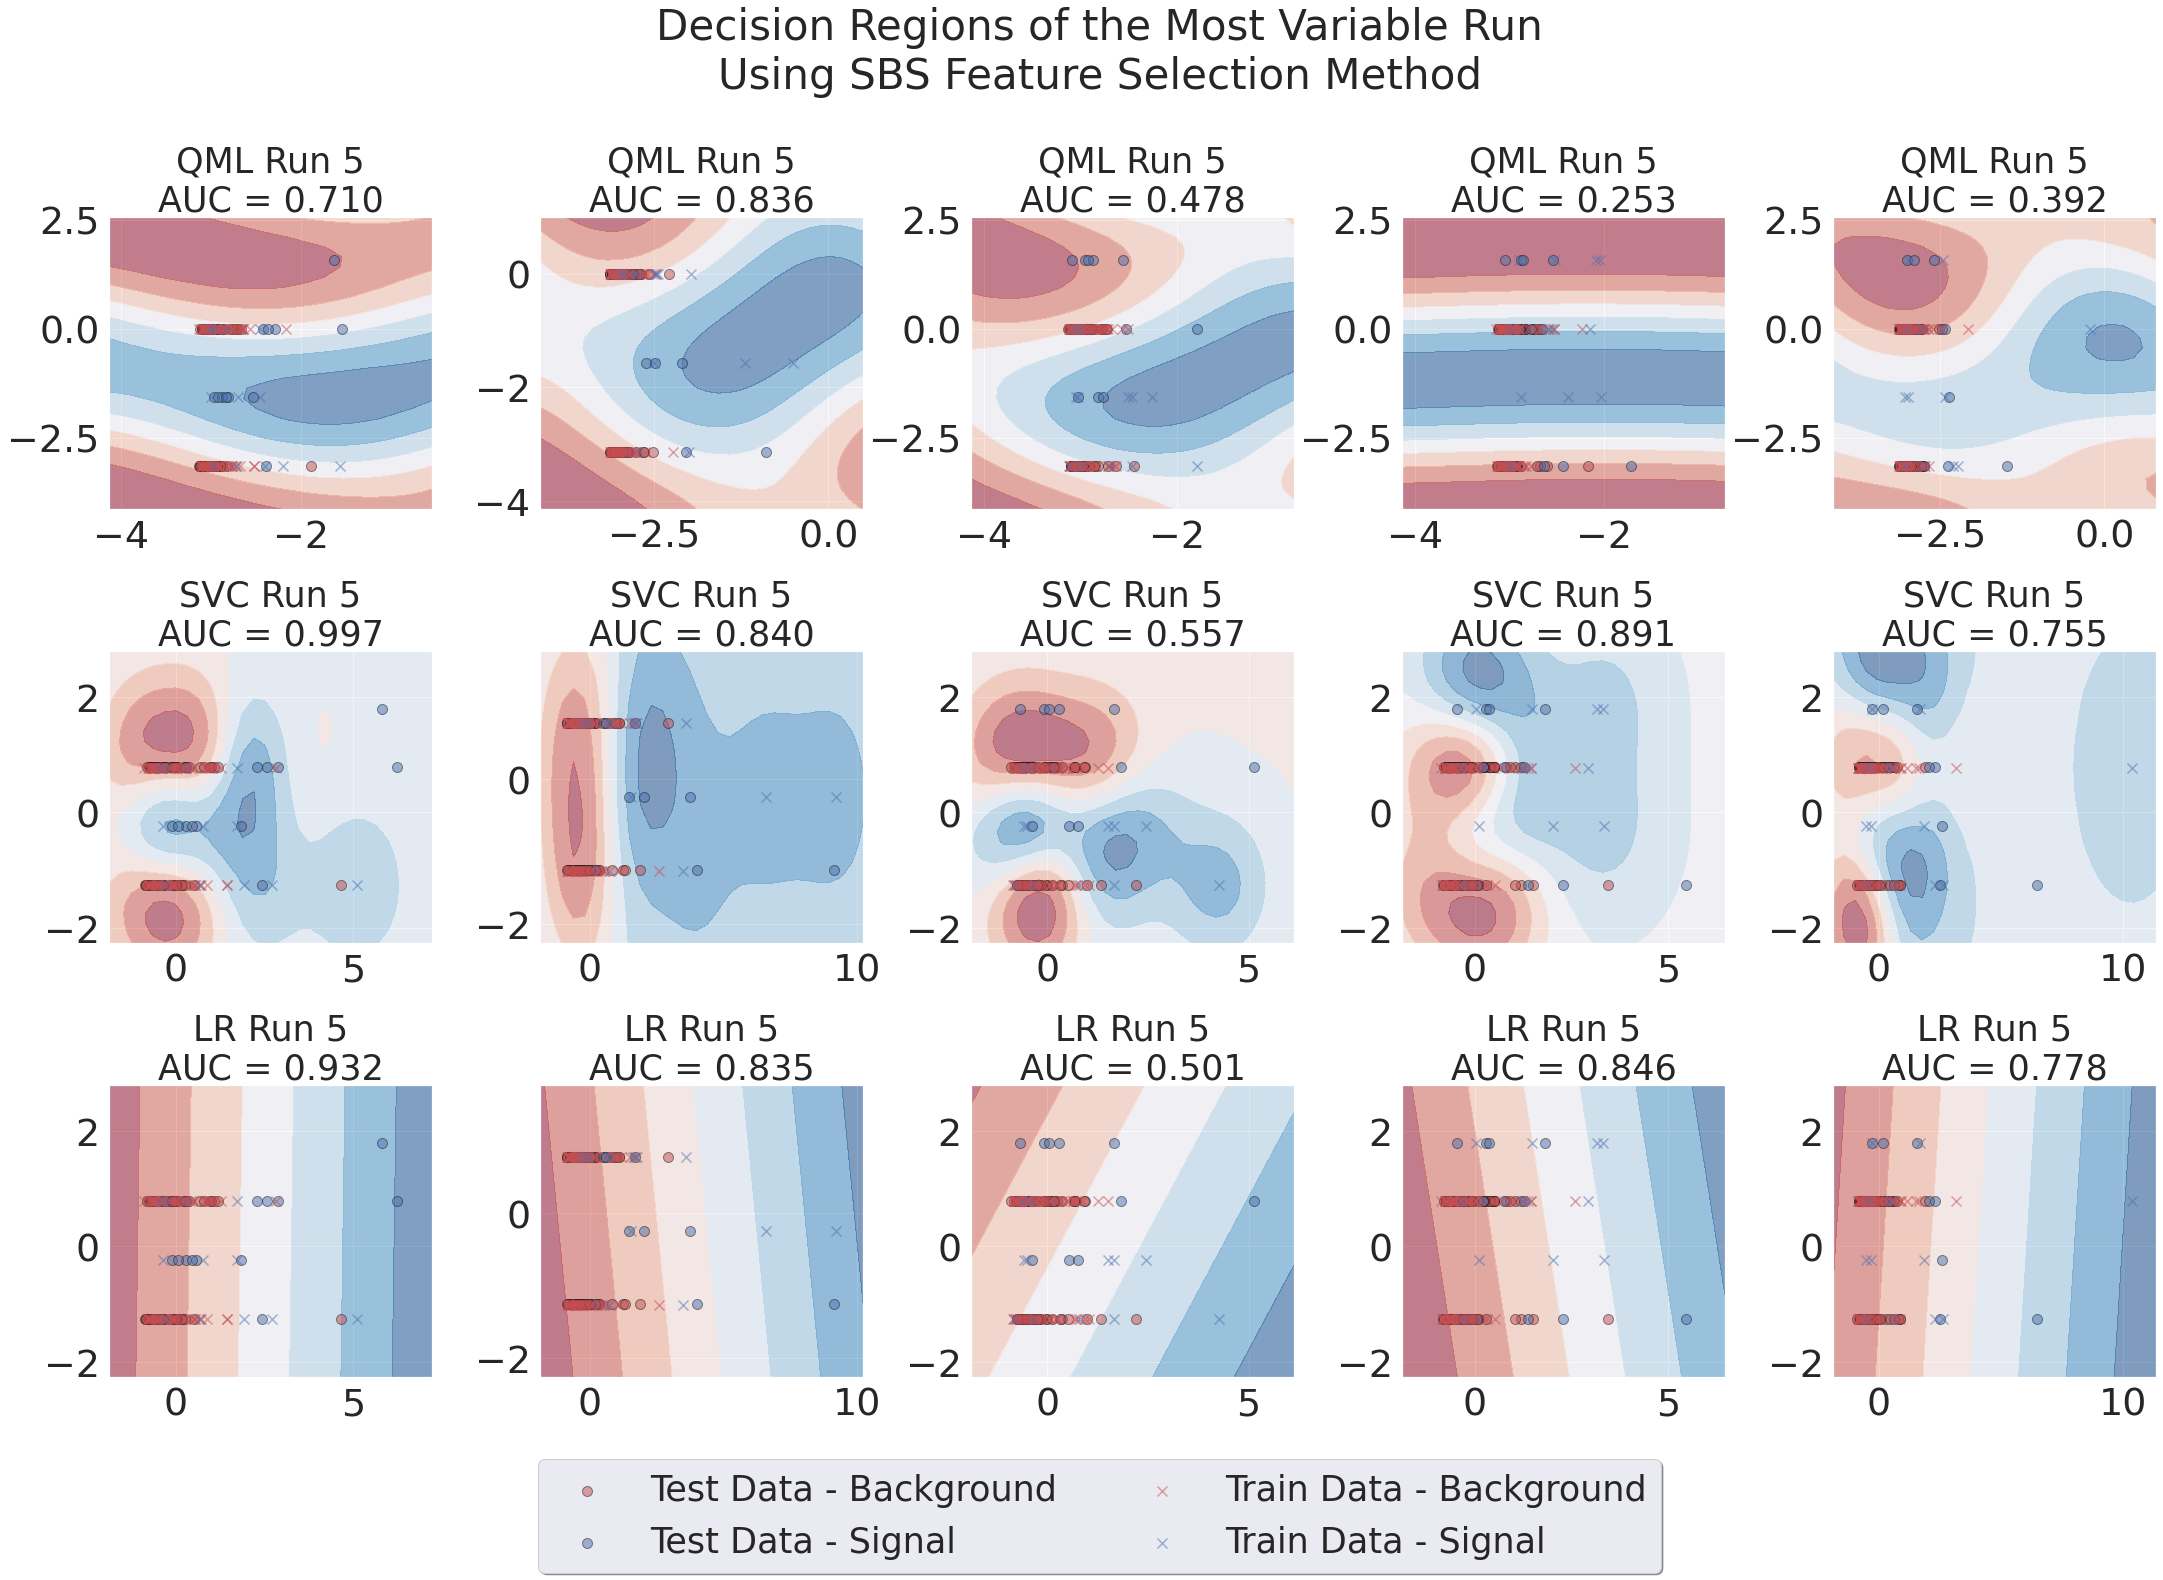

In [13]:
Plot_decision_regions(qml_worlds, svm_worlds, log_worlds, study, feature_method='SBS', title=f"Decision Regions of the Most Variable Run\nUsing SBS Feature Selection Method", save_name='variable_SBS')

## PCA

  0%|          | 0/5 [00:00<?, ?it/s]

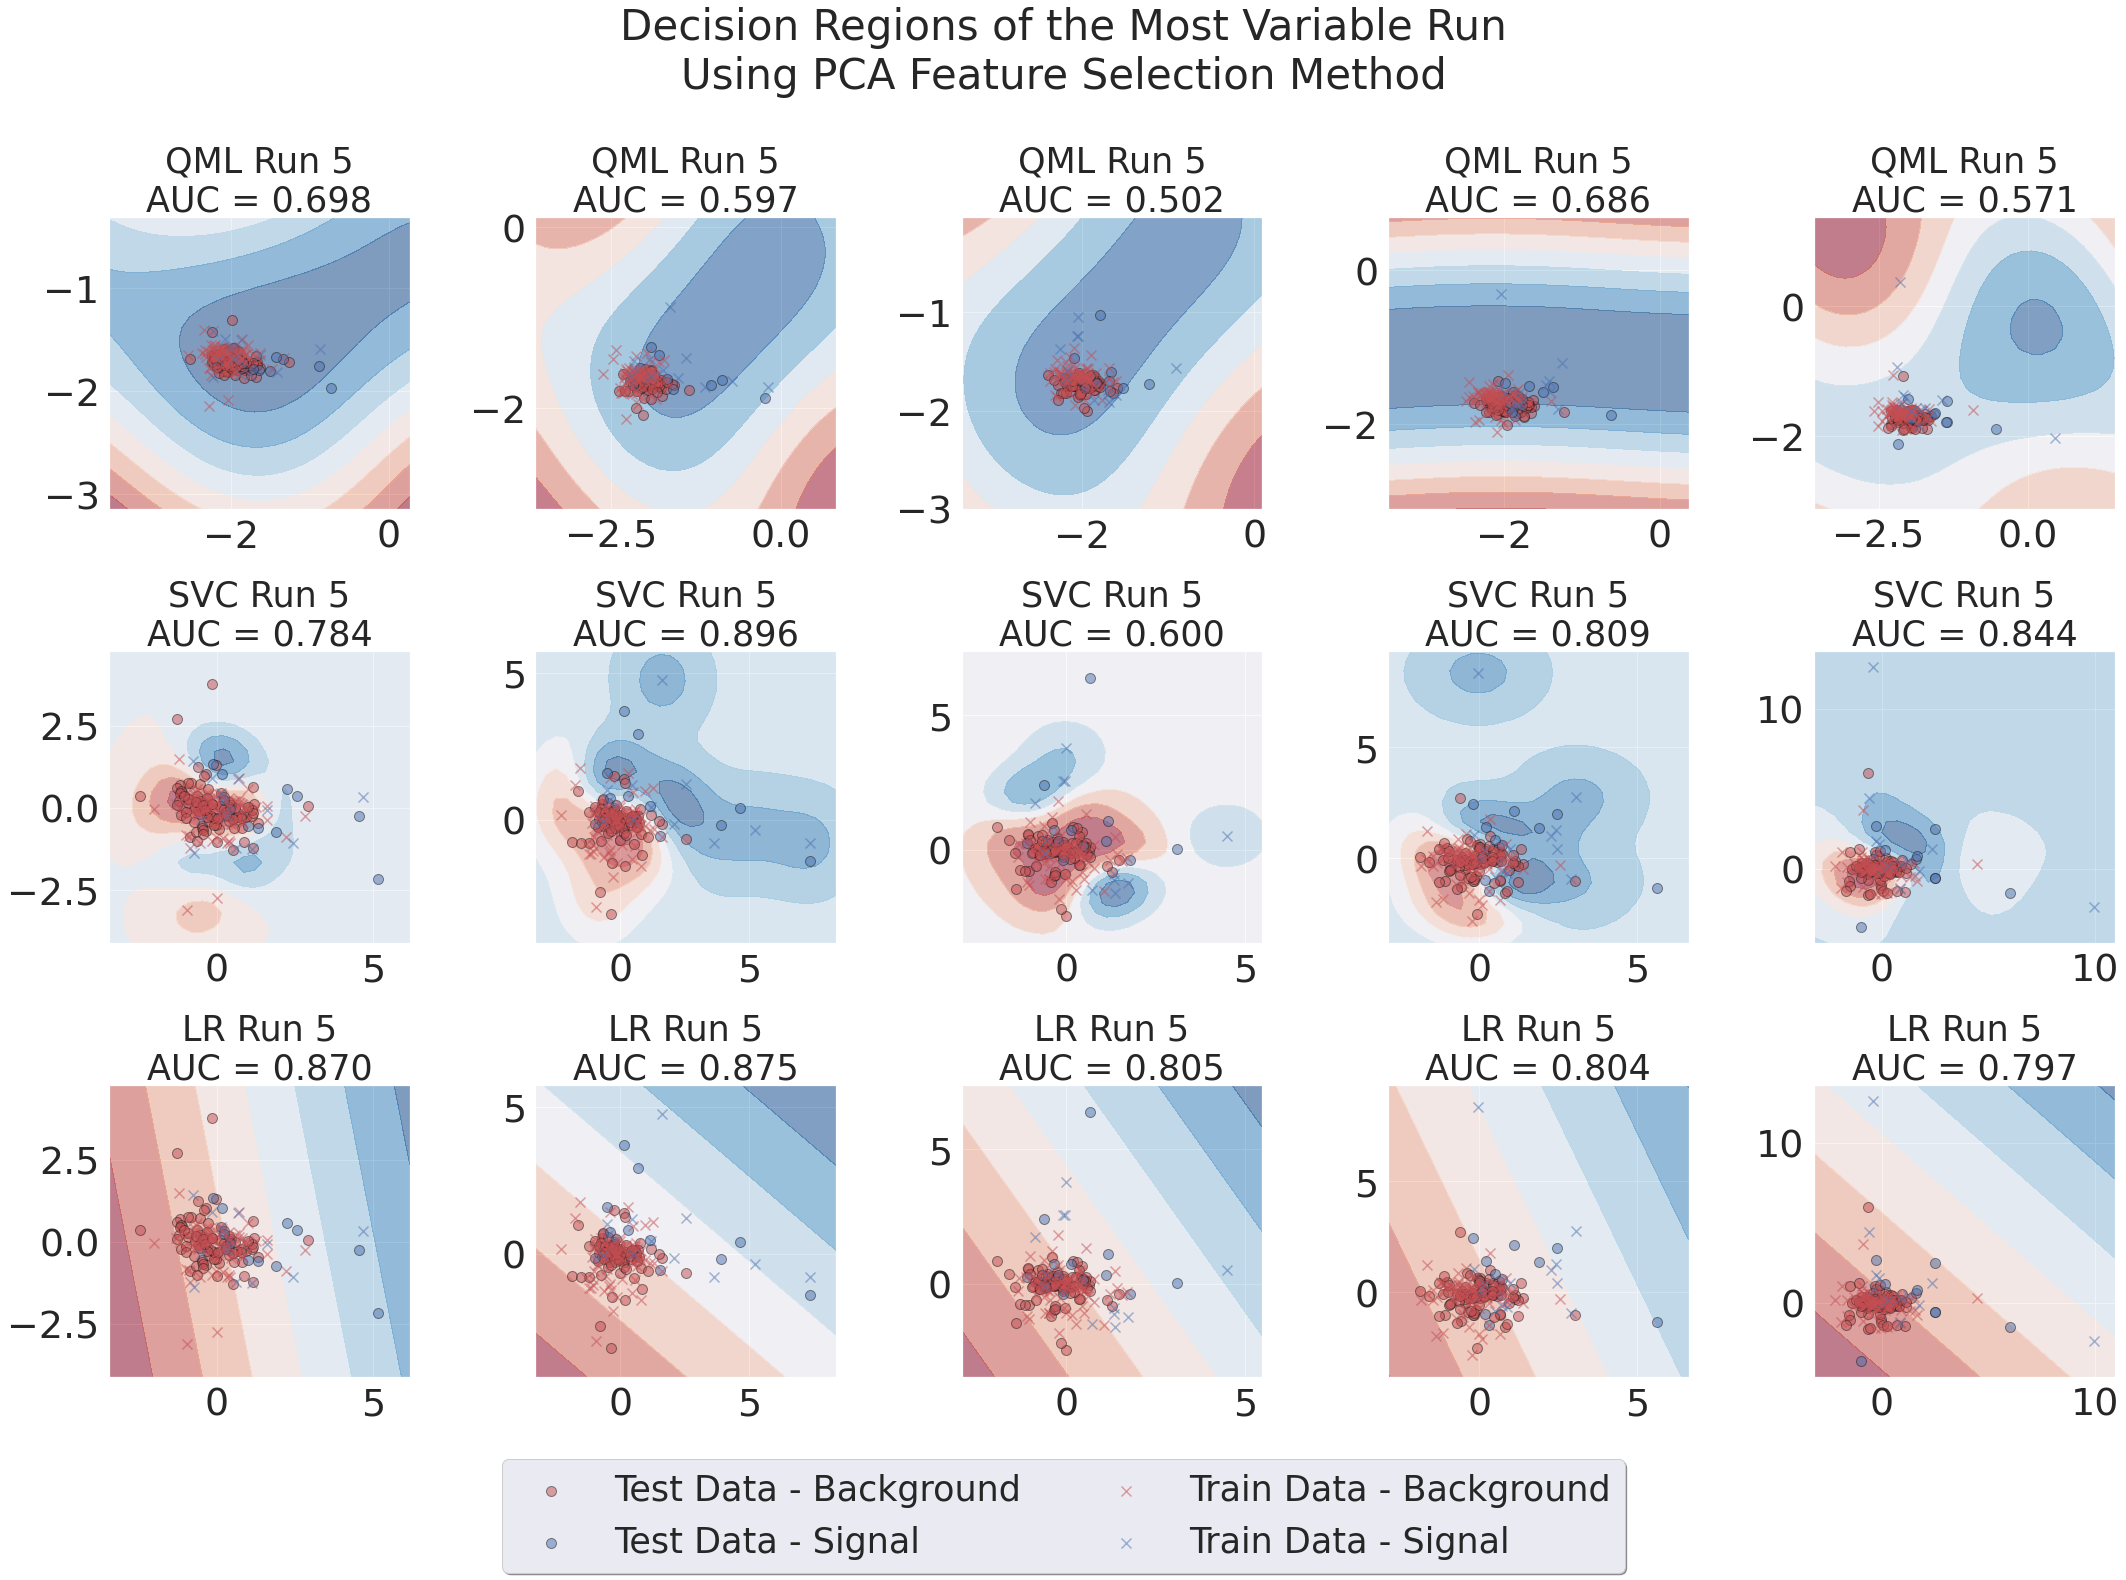

In [14]:
Plot_decision_regions(qml_worlds, svm_worlds, log_worlds, study, feature_method='PCA', title=f"Decision Regions of the Most Variable Run\nUsing PCA Feature Selection Method", save_name='variable_PCA')

# Least Variable Run

In [15]:
table = df[(df['Model'] == 'QML')].groupby(['Study', 'name', 'Feature Method', '#Datapoints'])['AUC'].std().sort_values(ascending=True)
table

Study        name  Feature Method  #Datapoints
AdamModel    8     PCA             5000           0.003339
             6     PCA             5000           0.003995
             7     PCA             5000           0.005454
OptunaModel  9     PCA             5000           0.005785
AdamModel    105   SBS             5000           0.006594
                                                    ...   
             183   SBS             100            0.194904
OptunaModel  181   SBS             100            0.212514
AdamModel    184   SBS             100            0.213633
OptunaModel  184   SBS             100            0.235423
AdamModel    181   SBS             100            0.236974
Name: AUC, Length: 80, dtype: float64

In [16]:
# Get the most variable
study = table.index[0][0]
name = table.index[0][1]

print("Loading worlds for study", study, "and name", name)

del qml_worlds, svm_worlds, log_worlds # just in case
with open(join(analisys_results_path, study, f"{name}.pkl"), "rb") as f:
        qml_worlds, svm_worlds, log_worlds = pickle.load(f)


assert len(qml_worlds) == len(svm_worlds) == len(log_worlds) == 5
qml_worlds[0]

Loading worlds for study AdamModel and name 8


{'feature_method': 'PCA',
 'n_datapoints': 5000,
 'n_features': 2,
 'n_layers': 4,
 'max_epochs': 500,
 'learning_rate': 0.03,
 'study_name': 'AdamModel',
 'name': '8_2030606455',
 'random_seed': 2030606455,
 'X_val': tensor([[-2.01316261, -1.7381115],
         [-2.31638861, -1.79721546],
         [-1.93697321, -1.85131264],
         ...,
         [-2.05607176, -1.82917249],
         [-2.36222982, -1.8045187],
         [-1.79015934, -1.86175346]], dtype=float32, requires_grad=False),
 'Y_val': tensor([1, 1, 1, ..., 0, 0, 0], requires_grad=False),
 'W_val': tensor([3.86919505, 3.86919505, 3.86919505, ..., 0.5742017 , 0.5742017 ,
         0.5742017 ], requires_grad=False),
 'Y_val_scores': tensor([0.16338268, 0.07279463, 0.1686976 , ..., 0.13460726, 0.06265542,
         0.21880906], requires_grad=True),
 'X_test': array([[-1.9075606, -1.6162982],
        [-0.8811982, -1.7560204],
        [-1.842531 , -1.733068 ],
        ...,
        [-2.153048 , -1.7304882],
        [-2.0509343, -1.7285

In [20]:
np.array([0.522, 0.523, 0.568, 0.55, 0.538]).std()

0.017325126262166153

## SBS

  0%|          | 0/5 [00:00<?, ?it/s]

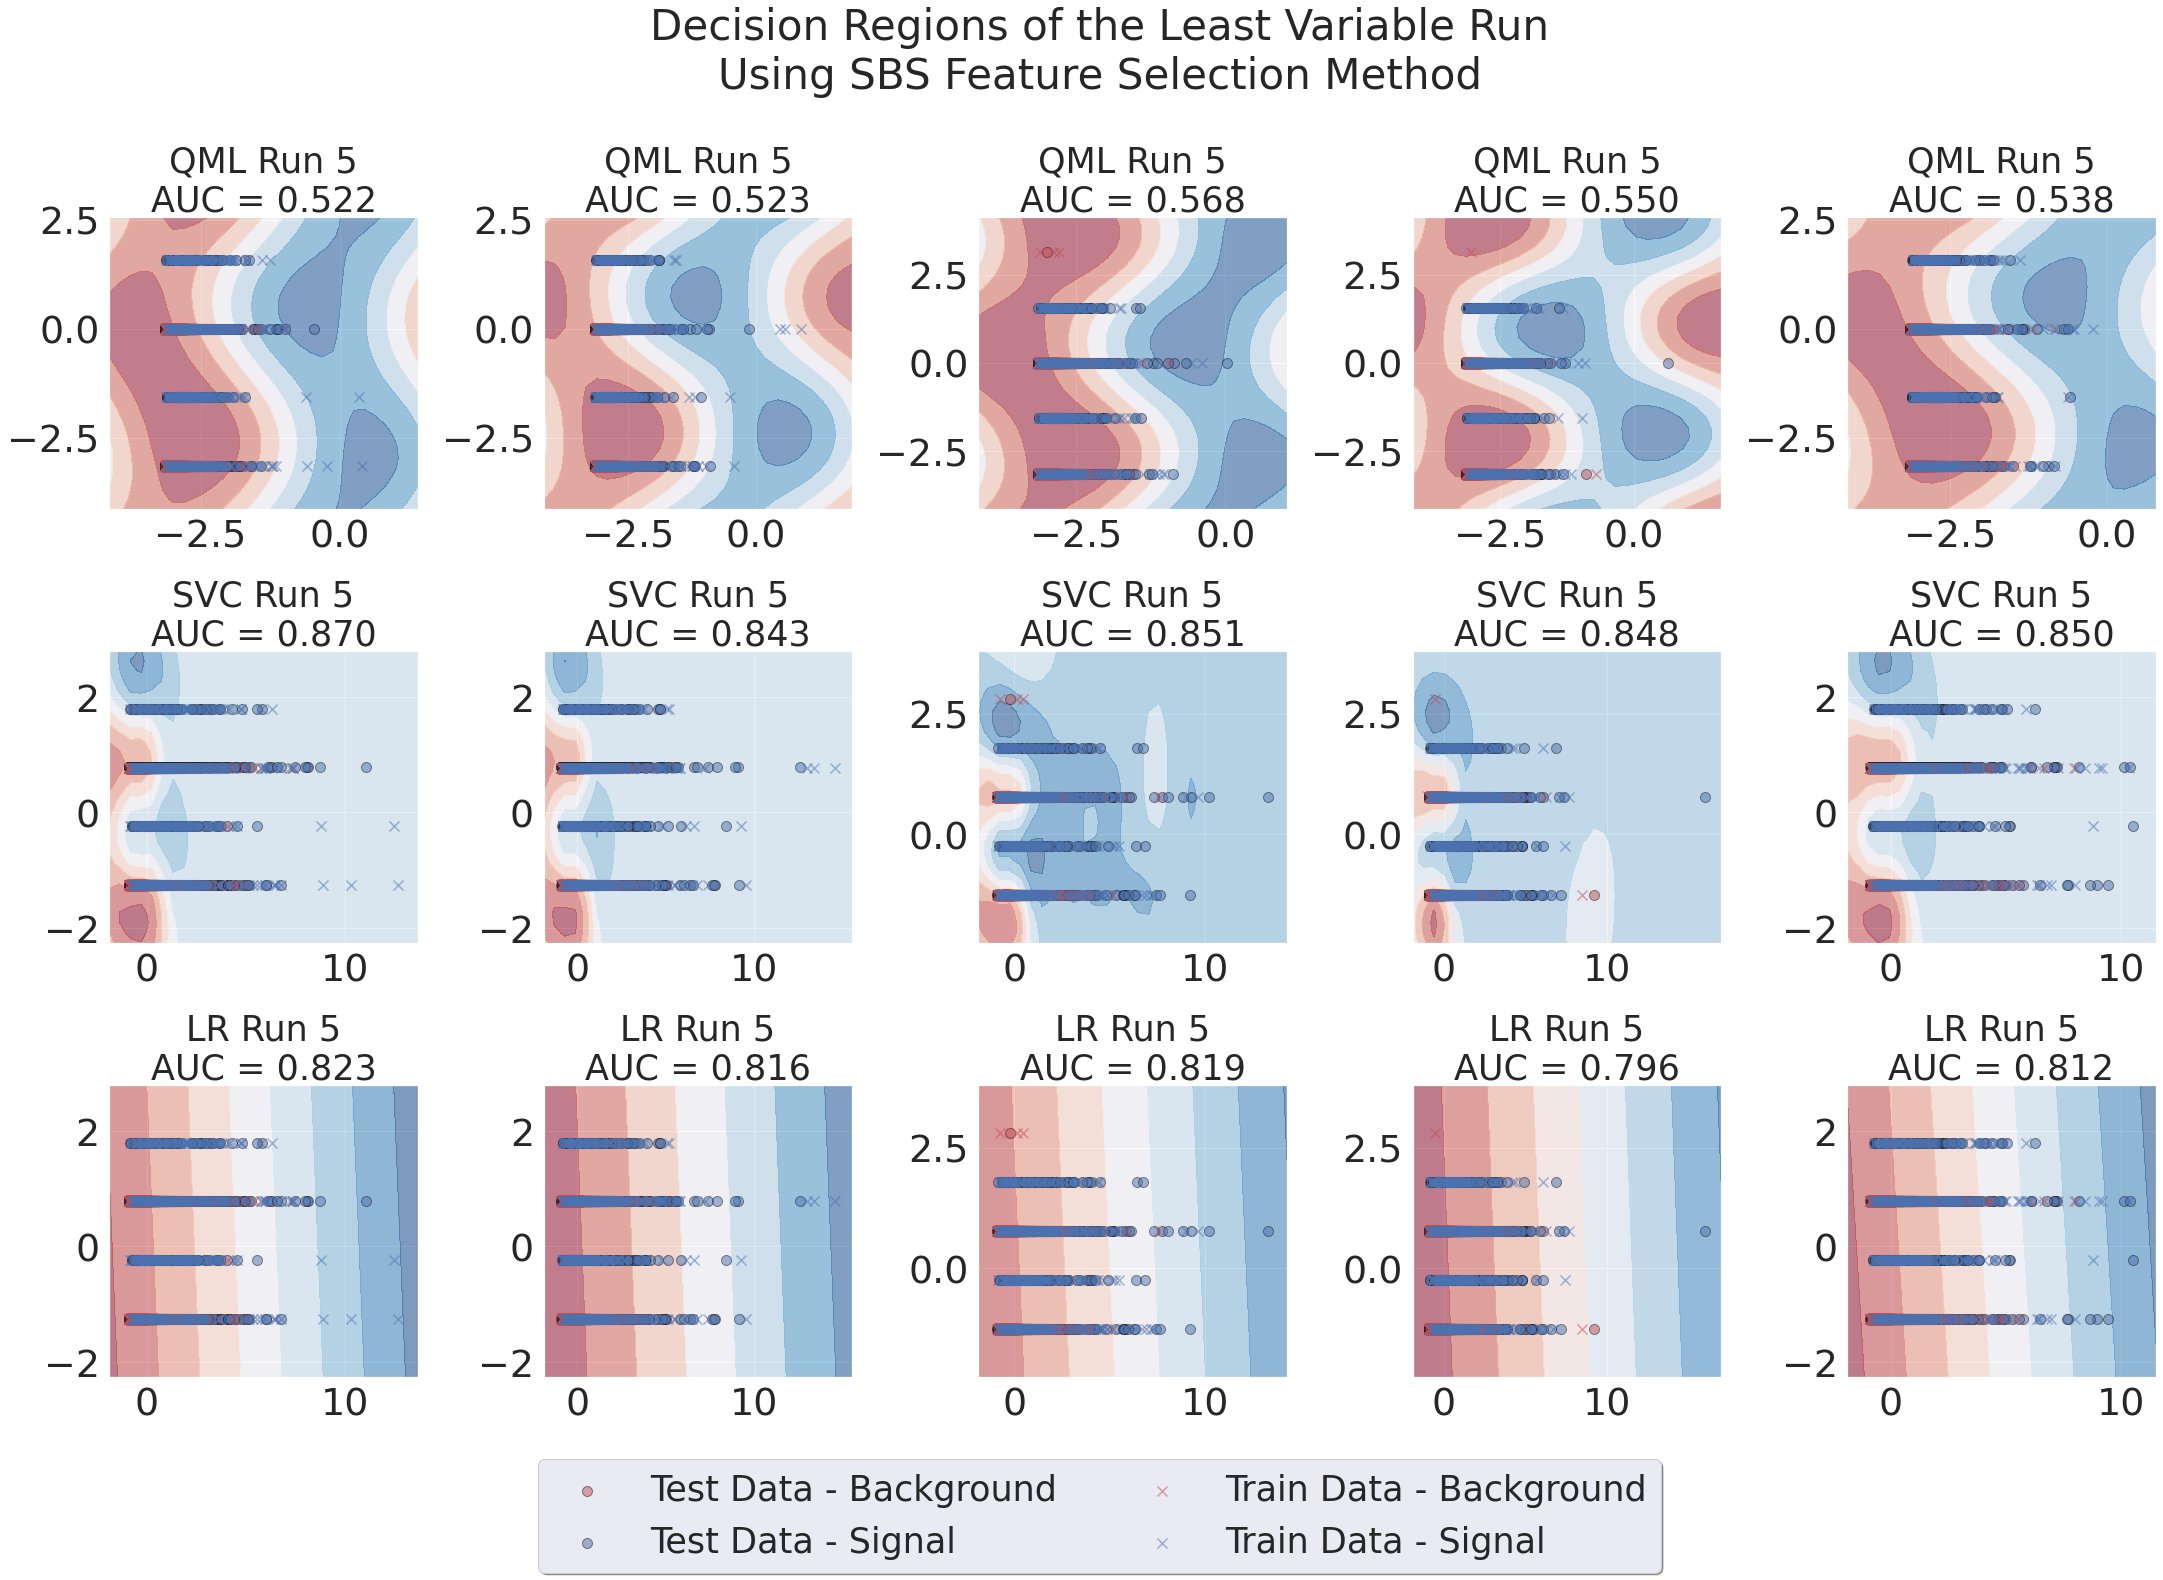

In [21]:
Plot_decision_regions(qml_worlds, svm_worlds, log_worlds, study, feature_method='SBS', title=f"Decision Regions of the Least Variable Run\nUsing SBS Feature Selection Method", save_name='least_variable_SBS')

In [23]:
df[(df['Model'] == 'QML') & (df['Study'] == study) & (df['name'] == name)]['AUC'] # NOTE: EXPECTED AUC VALUES FOR PCA!

525    0.761562
526    0.762753
527    0.763639
528    0.755522
529    0.758554
Name: AUC, dtype: float64

## PCA

  0%|          | 0/5 [00:00<?, ?it/s]

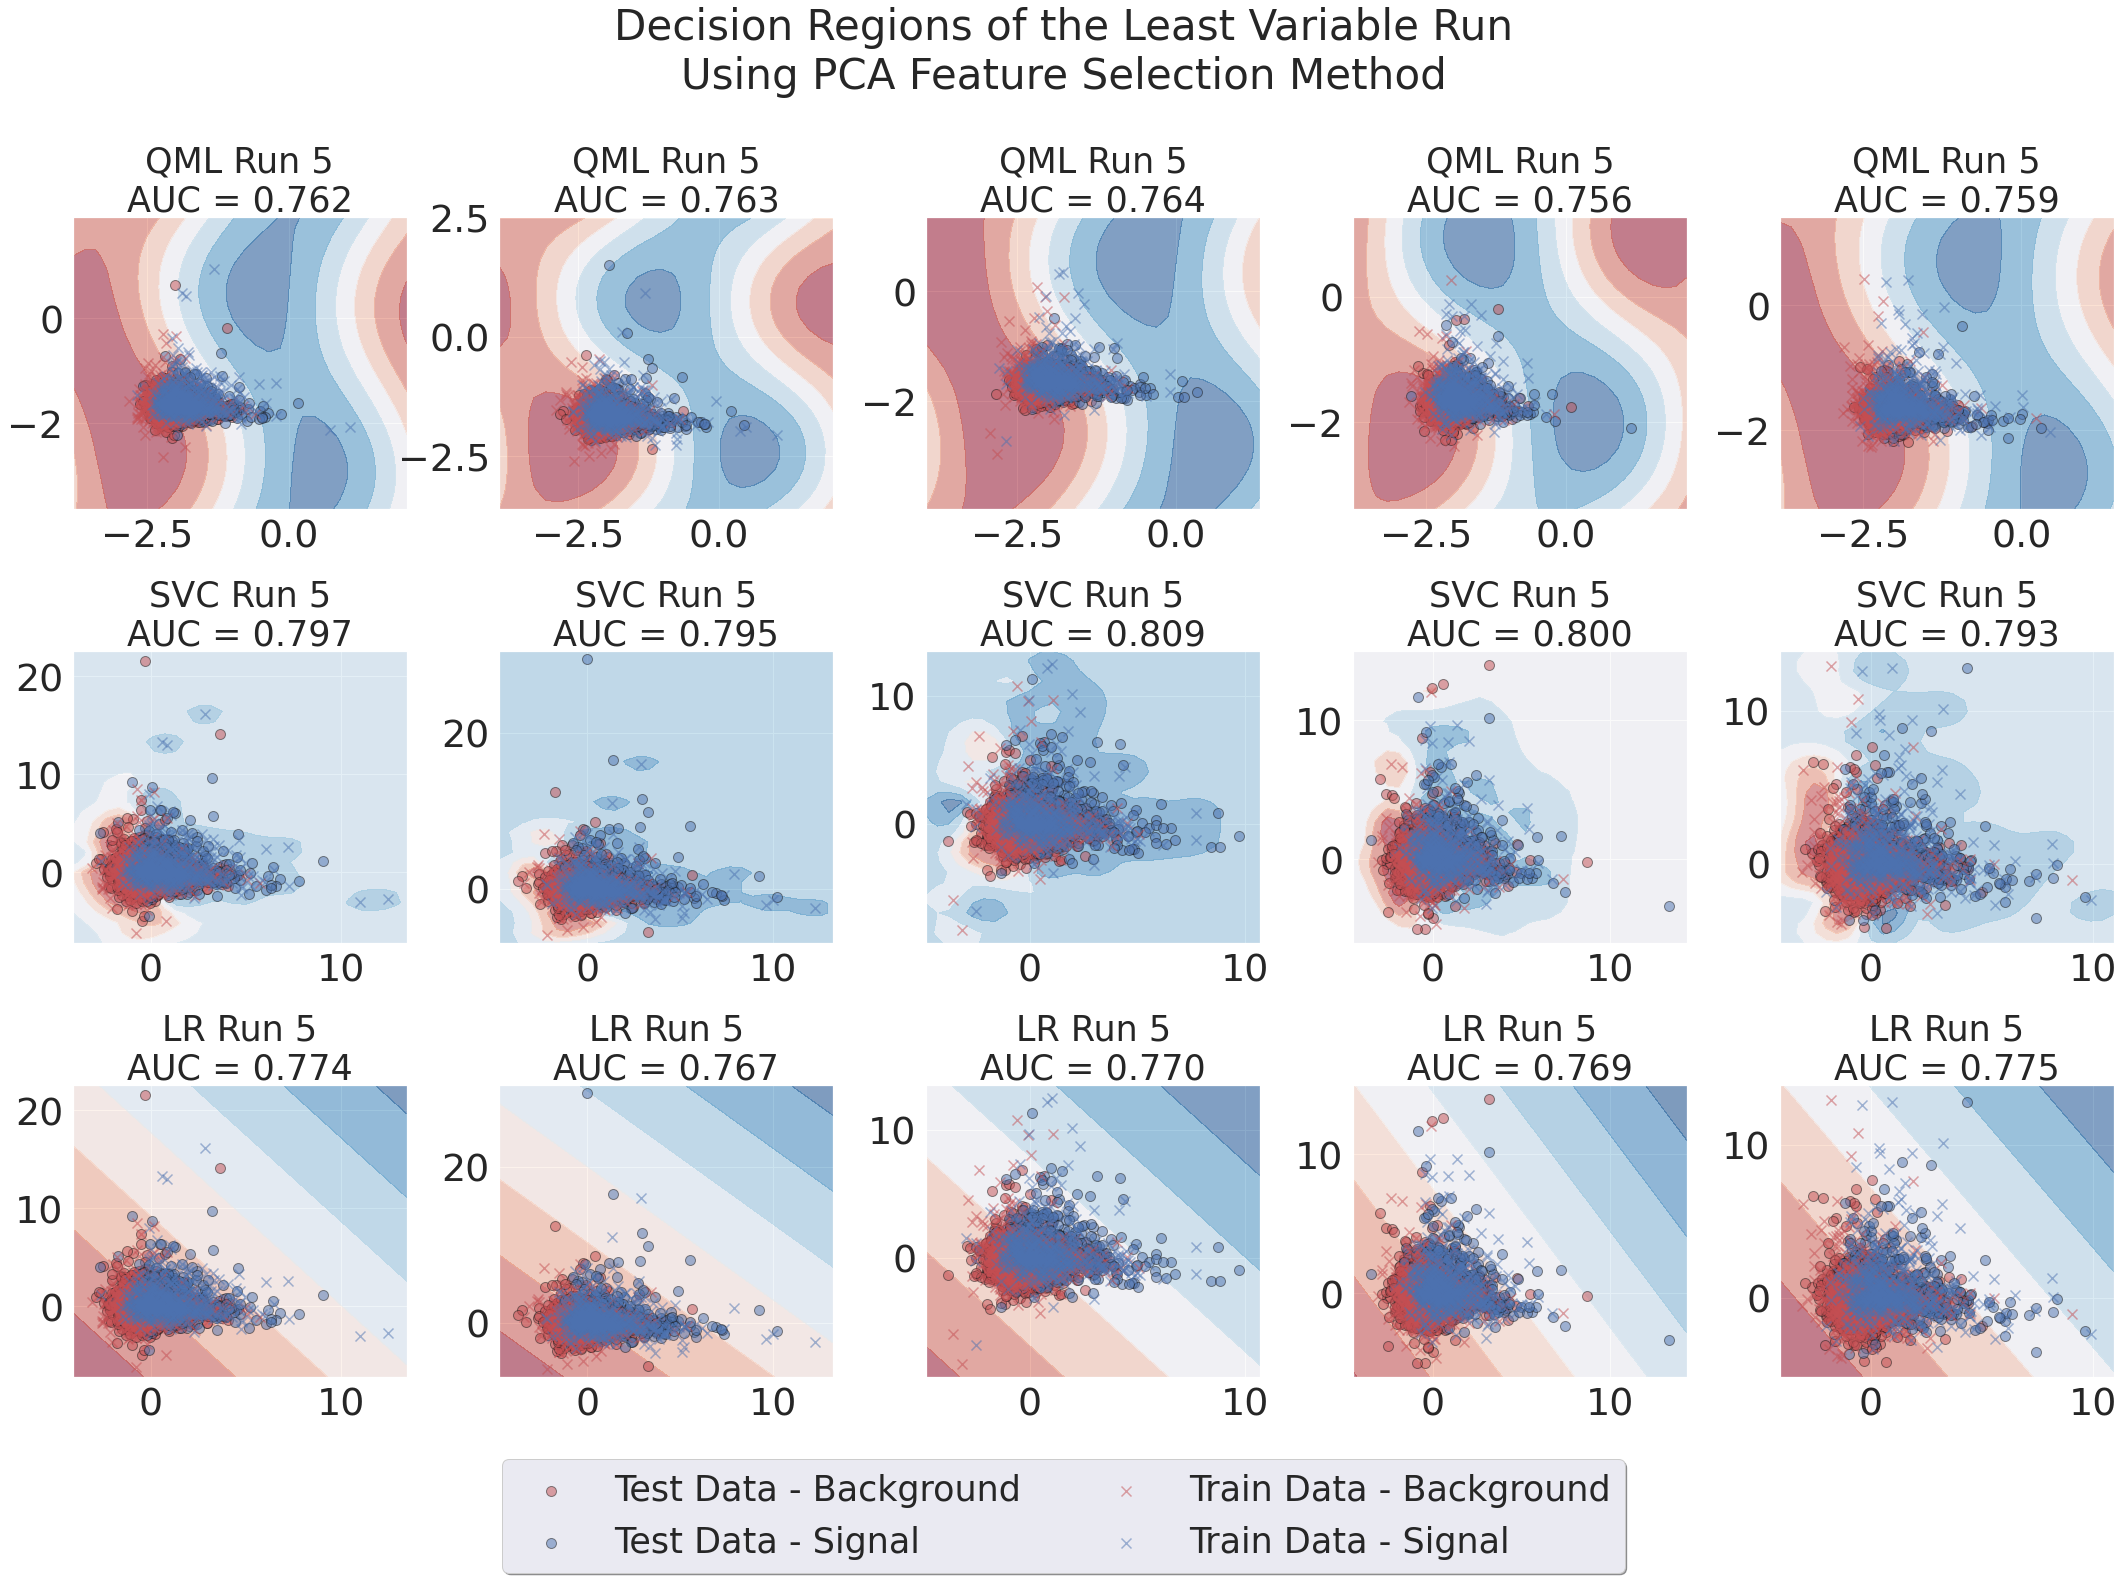

In [24]:
Plot_decision_regions(qml_worlds, svm_worlds, log_worlds, study, feature_method='PCA', title=f"Decision Regions of the Least Variable Run\nUsing PCA Feature Selection Method", save_name='least_variable_PCA')